# CRISP-DM

Vanwege het tekort aan piloten willen we onderzoeken of we kunnen voorspellen binnen hoeveel maanden een medewerker vertrekt. Ons doel is om het aantal vertrekkende werknemers voor de komende maand te voorspellen (data mining doel).

Deze data-oplossing is de oplossing die wij als groep gaan inleveren voor ons business probleem. Om hem toch mijn eigen te make heb ik alles in mijn woorden geschreven. Ook heb ik geprobeerd de SHAP beter leesbaar te maken en maak ik visualisaties om de uitkomst beter te begrijpen en inzichten te krijgen

In [182]:
import pandas as pd
import numpy as np

In [183]:
temp_df = pd.read_feather('employee_data_complete.feather')

In [184]:
# Makkelijker om terug te gaan naar origineel
df = temp_df.copy()

## 2. Understanding the data

In [185]:
df.head(3)

,First name,Last name,Position title,Employee engagement,Full name,Age,Base pay (full-time),Base pay (full-time) - currency,Base pay (part-time),Base pay (part-time) - currency,...,Time to hire,Time to lateral move,Time to promotion,Time to start,Total labor cost (in original currency),Total labor cost (in original currency) - currency,Work location,Work related accident,Years in position,Years of service
Timeslice,,,,,,,,,,,,,,,,,,,,,
2020-08-31,Shara,'s Gravensande,Communications Officer,35,Shara 's Gravensande,27.333333,27119.000000,EUR,27119.000000,EUR,...,NaN,NaN,NaN,NaN,35135.57,EUR,Hybrid,False,0.166667,3.166667
2020-08-31,Fronie,'s Gravensande,Marketing Manager,38,Fronie 's Gravensande,41.333333,104744.183078,EUR,83795.346462,EUR,...,NaN,NaN,NaN,NaN,240341.59,AUD,Remote,False,4.083333,10.083333
2020-08-31,Viridiana,'s Gravensande,Aviation Planner,48,Viridiana 's Gravensande,26.083333,40653.175698,EUR,40653.175698,EUR,...,NaN,NaN,NaN,NaN,58135.87,USD,Onsite,False,0.166667,3.166667


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1087078 entries, 2020-08-31 to 2024-05-31
Columns: 109 entries, First name to Years of service
dtypes: bool(3), float64(30), int64(10), object(66)
memory usage: 890.5+ MB


Ik ga onderzoeken wat de datum is dat piloten in dienst zijn.

In [187]:
df['Date in position'].head(3)

Timeslice
2020-08-31    2020-06-15
2020-08-31    2016-07-01
2020-08-31    2020-06-26
Name: Date in position, dtype: object

Boolean: True betekend deze maand (index) weggegaan, False betekend blijvende medewerker

In [188]:
df['Is leaver'].head(3)

Timeslice
2020-08-31    False
2020-08-31    False
2020-08-31    False
Name: Is leaver, dtype: bool

## 3. Data preparation

Gezien de casus, focussen wij ons nu alleen op de piloten

In [189]:
df = df[df['Functional area level 2'] == 'Pilots']

Datum toevoegen bij vertrekkers, bij elke record van deze mederwerker, wanneer hij uit dienst is gegaan

In [190]:
# Create a new column with NaN values as default
df['Date out of service'] = np.nan

# Update the 'Date out of service' column where 'Is leaver' is True
df.loc[df['Is leaver'] == True, 'Date out of service'] = df.loc[df['Is leaver'] == True].index

# Now, propagate the 'Date out of service' across all rows for each employee
df['Date out of service'] = df.groupby('Employee ID')['Date out of service'].transform('max')


In [191]:
df['Date out of service'] = pd.to_datetime(df['Date out of service'])

In [192]:
df['Date out of service'].head(5)

Timeslice
2020-08-31          NaT
2020-08-31          NaT
2020-08-31          NaT
2020-08-31   2021-09-30
2020-08-31   2023-05-31
Name: Date out of service, dtype: datetime64[ns]

Voor elke rij berekenen over hoeveel dagen deze werknemer wegging

In [193]:
df['Days till leave'] = (df['Date out of service'] - df.index).dt.days

In [194]:
df['Days till leave'].head(5)

Timeslice
2020-08-31       NaN
2020-08-31       NaN
2020-08-31       NaN
2020-08-31     395.0
2020-08-31    1003.0
Name: Days till leave, dtype: float64

Alleen medewerkers die zijn vertrokken selecteren

In [195]:
df_filtered = df[df['Days till leave'].notna()]
df_filtered[['Employee ID', 'Is hire', 'Is leaver', 'Date in service', 'Date out of service', 'Days till leave', 'Employee engagement']].head(3)


,Employee ID,Is hire,Is leaver,Date in service,Date out of service,Days till leave,Employee engagement
Timeslice,,,,,,,
2020-08-31,E21672,True,False,2009-06-26,2021-09-30,395.0,90
2020-08-31,E8092,False,False,2012-06-15,2023-05-31,1003.0,26
2020-08-31,E7451,False,False,2011-07-01,2021-05-31,273.0,59


In [196]:
from sklearn.model_selection import train_test_split

# Onafhankelijke variabele
X = df_filtered.select_dtypes(include=[np.float64, np.int64]).drop(columns=['Days till leave'])  # Exclude the target variable

# Afhankelijke variabele
y = df_filtered['Days till leave']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. Modeling

Ik heb gekozen voor een DecisionTreeRegressor (beslisboom) omdat dit model goed presteert zonder veel aanpassingen aan de instellingen. In tegenstelling tot neurale netwerken levert een beslisboom vaak al redelijk goede resultaten met de standaardinstellingen. Een ander voordeel is dat beslisbomen duidelijk en makkelijk te interpreteren zijn, waardoor ik met behulp van SHAP-waarden én LIME kan begrijpen waarom het model een bepaalde voorspelling doet, zelfs als die niet correct is. Door SHAP en LIME samen toe te passen, krijg ik nog meer inzicht in de voorspellingen van het model, wat menselijke controle vergemakkelijkt en besluitvorming ondersteunt. Bovendien zijn beslisbomen snel te trainen, zelfs met beperkte rekenkracht, vergeleken met neurale netwerken.

Op een later moment kan ik nog kiezen om een neuraal netwerk te gebruiken voor deze data. Een nadeel hiervan is dat de uitlegbaarheid van het model dan minder wordt. Hoewel SHAP-waarden en LIME ook op neurale netwerken toegepast kunnen worden, geven ze slechts een inschatting van de beslissingen van het model en geen volledige verklaring.

In [197]:
from sklearn.tree import DecisionTreeRegressor


# Decision Tree Regression
# Feedback: Waarom heb je gekozen voor Decisiontree. 
model = DecisionTreeRegressor(random_state=42)  # Set random_state for reproducibility
model.fit(X_train, y_train)

# Making predictions on the test set
predictions = model.predict(X_test)

## 5. Evaluation

### R2 score

Ik heb gekozen voor de R²-score omdat deze aangeeft welk percentage van de variatie in de afhankelijke variabele (dagen tot vertrek) wordt verklaard door de onafhankelijke variabelen in het model. Ook als ik niet precies weet hoeveel dagen afwijking acceptabel is voor een voorspelling, kan ik met de R²-score toch bepalen hoe goed het model presteert. Kortom, de R²-score biedt een eenvoudige manier om het model te interpreteren.

In [198]:
from sklearn.metrics import r2_score, mean_absolute_error
# Calculating R² score on the test set. Waarom voor r2 score score gekozen en niet voor mse/mae en nog veel meer. 
r2_value = r2_score(y_test, predictions)

# Displaying results
print("R² value:", r2_value)


R² value: 0.9507146724860892


### Gemiddelde absolute afwijking

Ik heb gekozen voor de gemiddelde absolute afwijking omdat deze eenvoudig te interpreteren is. Het geeft de fout weer in dezelfde eenheid als de afhankelijke variabele. Dus als er een afwijking van 44 dagen wordt weergegeven, betekent dit dat het model er gemiddeld genomen 44 dagen naast zit.

In [199]:
mae_value = mean_absolute_error(y_test, predictions)

print("Mean Absolute Error (MAE):", mae_value)

Mean Absolute Error (MAE): 44.68818040435459


Ik heb voor SHAP waarden gekozen omdat deze methode erg goed is in het uitleggen van complexe modellen, zoals beslisbomen. 
<br> Daarnaast zullen de SHAP waarden altijd overeenkomen met de keuze van het model (De som van de SHAP waarden is gelijk aan de voorspelling van het model). <br>
<br> Bij de LIME methode is dit niet het geval. Hierbij wordt er een lokaal interpreteerbaar model getrained op gegevens rond de specifieke invoer. <br>
Dit betekend dat de som van de bijdragen van features in LIME niet altijd gelijk is aan de voorspelling van het oorspronkelijke model. <br>
Om deze reden heb ik voor SHAP waarden gekozen. 

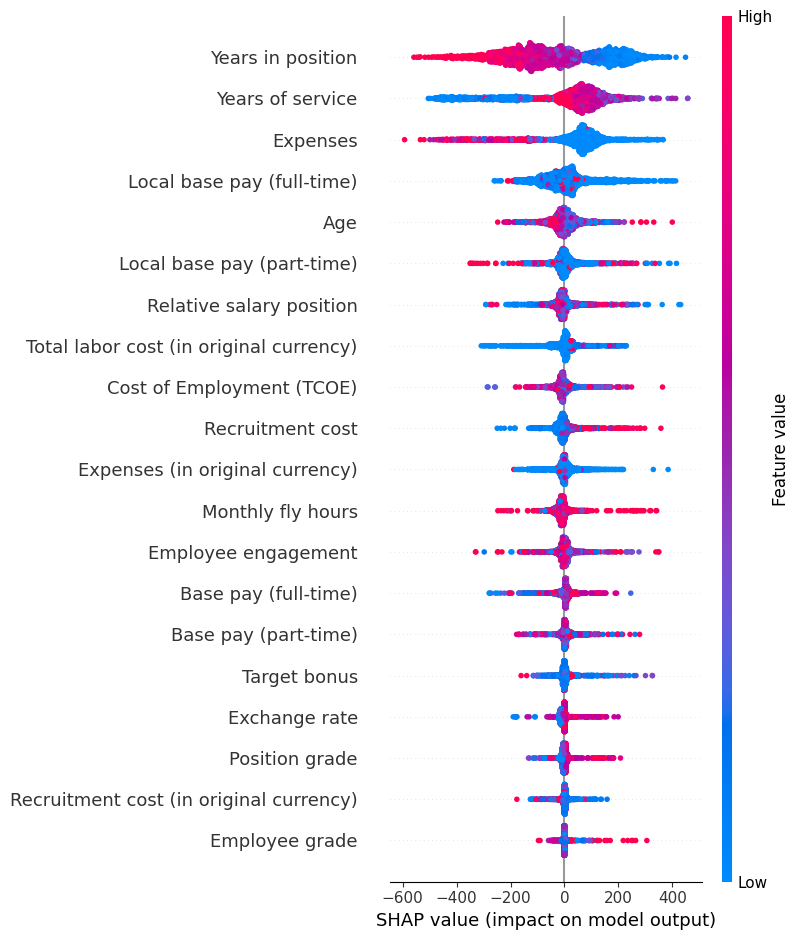

In [200]:
import shap
import matplotlib.pyplot as plt
# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set, with check_additivity set to False
shap_values = explainer(X_test, check_additivity=False)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test)


De samenvattingsplot hierboven laat zien hoe belangrijk elke feature is en wat het effect is op de voorspelling. Elke punt in de plot staat voor een specifieke waarde van een feature op een bepaalde datarij, waarbij de y-as de feature aanduidt en de x-as de bijbehorende Shapley-waarde toont. Kleuren laten zien hoe hoog of laag een feature-waarde is, en de verdeling blijft zichtbaar door de lichte verschuiving van de punten. De features worden gerangschikt op volgorde van hun belang voor het model.

Wat betreft feature_importance: lage uitgaven van piloten lijken samen te hangen met langere dienstverbanden volgens het model. Ook blijkt dat hoe langer iemand in dezelfde functie blijft, hoe sneller ze volgens het model geneigd zijn te vertrekken. Tot slot verwacht het model dat piloten met lagere kosten langer blijven.

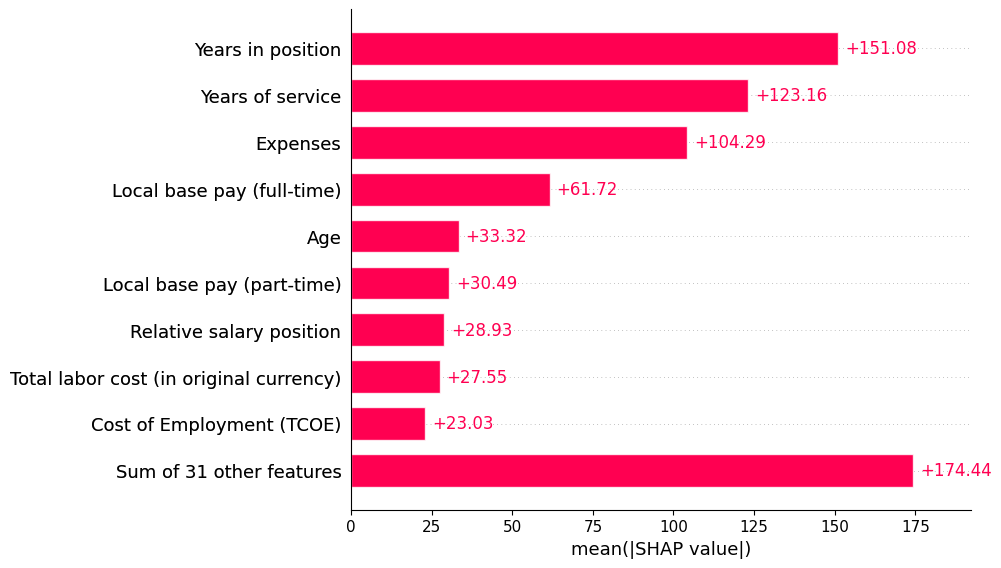

In [201]:
# Plot SHAP feature importance
shap.plots.bar(shap_values)

In [202]:
# full_X = df.select_dtypes(include=[np.float64, np.int64]).drop(columns=['Days till leave', 'Years in position', 'Years of service', 'Age', 'Predicted Days till Leave'])  # Exclude target variable
full_X = df.select_dtypes(include=[np.float64, np.int64]).drop(columns=['Days till leave'])  # Exclude target variable

# Make predictions on the entire DataFrame
full_predictions = model.predict(full_X)

results = df.copy()
# Add predictions to the DataFrame
results['Predicted Days till Leave'] = full_predictions



SHAP waarden berekenen en in een DataFrame zetten

In [203]:
# Calculate SHAP values
explainer = shap.Explainer(model, full_X)  # Create an explainer for your model
shap_values = explainer(full_X, check_additivity=False)  # Calculate SHAP values

# Create a DataFrame for SHAP values
shap_df = pd.DataFrame(shap_values.values, columns=full_X.columns)


 99%|===================| 68497/69230 [01:01<00:00]        

## 6. Deployment 

### Explainability

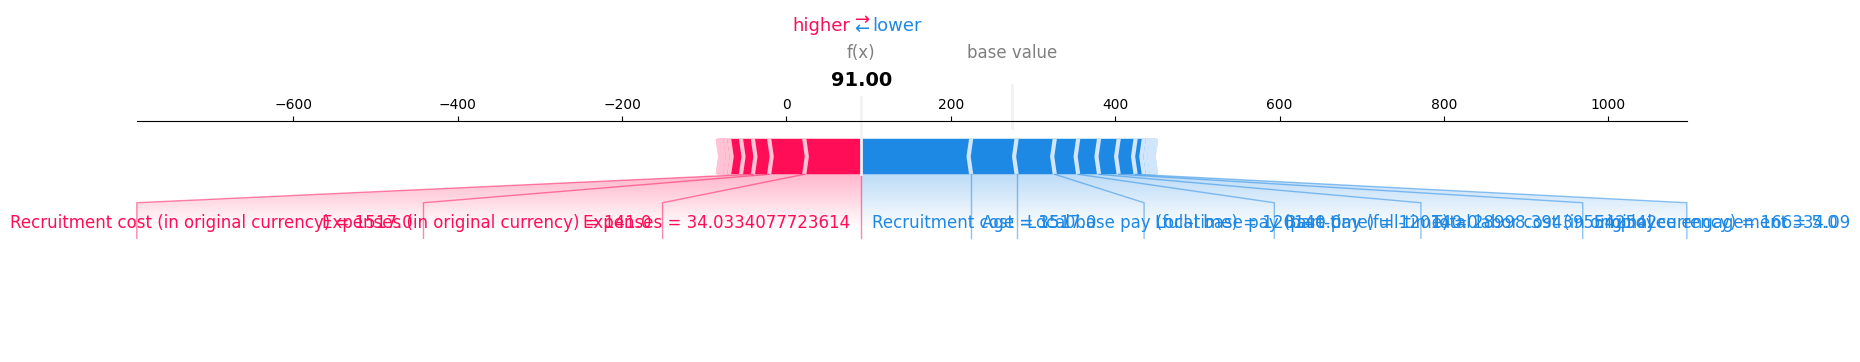

In [204]:
instance_index = 2
shap.force_plot(explainer.expected_value, shap_values[instance_index].values, full_X.iloc[instance_index], matplotlib=True)

Om het beter leesbaar te maken wil ik enkel de top 5 waarde die invloed hebben tonen.

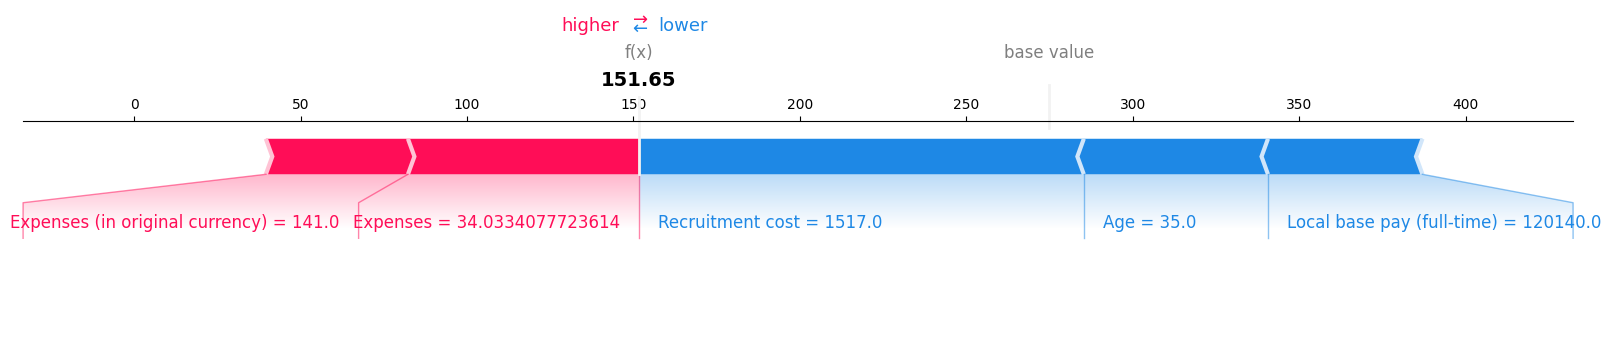

In [205]:
# Aantal top kenmerken die je wilt weergeven
top_features = 5  

# Haal de SHAP waarden voor een specifieke instantie op
instance_index = 2
shap_values_instance = shap_values[instance_index].values
feature_values_instance = full_X.iloc[instance_index]

# Bepaal de indices van de top meest invloedrijke kenmerken
top_feature_indices = np.argsort(np.abs(shap_values_instance))[-top_features:]

# Selecteer alleen de SHAP waarden en kenmerken voor deze top features
shap_values_top = shap_values_instance[top_feature_indices]
feature_values_top = feature_values_instance.iloc[top_feature_indices]
feature_names_top = feature_values_instance.index[top_feature_indices]

# Genereer de force plot met alleen de top kenmerken
shap.force_plot(
    explainer.expected_value,
    shap_values_top,
    feature_values_top,
    feature_names=feature_names_top,
    matplotlib=True
)


Resultaten laatste maand weergeven

In [206]:
df_last_month = results[results.index == '2024-07-31']  # Adjust date based on your index

In [207]:
number_of_rows = len(df_last_month)
print(f"Aantal rijen in de DataFrame: {number_of_rows}")

Aantal rijen in de DataFrame: 1604


In [208]:
df_last_month[[ 'Predicted Days till Leave', 'Employee engagement']].head(5)

,Predicted Days till Leave,Employee engagement
Timeslice,,
2024-07-31,0.0,17
2024-07-31,1126.0,72
2024-07-31,-89.0,100
2024-07-31,30.0,5
2024-07-31,1004.0,45


In [209]:
# Stap 1: Maak een nieuwe kolom voor de datum
reference_date = pd.to_datetime('2024-07-31')

# Voeg de dagen tot vertrek toe aan de referentiedatum om de datum van vertrek te berekenen
df_last_month['Departure Date'] = reference_date + pd.to_timedelta(df_last_month['Predicted Days till Leave'], unit='D')

# Print de eerste paar rijen van het bijgewerkte DataFrame om te controleren
df_last_month[['Employee ID', 'Functional area level 2', 'Predicted Days till Leave', 'Departure Date']].head(5)


,Employee ID,Functional area level 2,Predicted Days till Leave,Departure Date
Timeslice,,,,
2024-07-31,E7459,Pilots,0.0,2024-07-31
2024-07-31,E38277,Pilots,1126.0,2027-08-31
2024-07-31,E7620,Pilots,-89.0,2024-05-03
2024-07-31,E7406,Pilots,30.0,2024-08-30
2024-07-31,E7210,Pilots,1004.0,2027-05-01


### Visualisaties

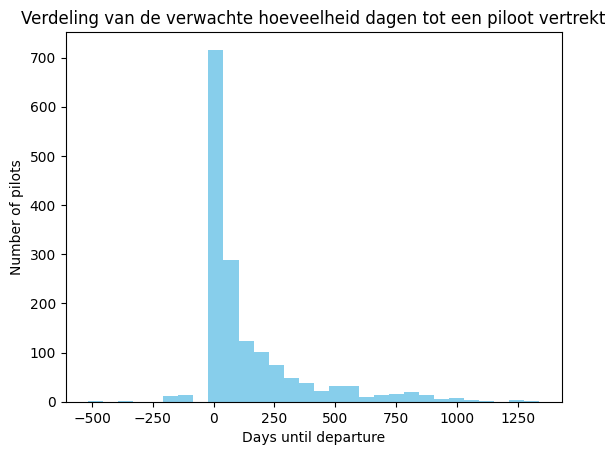

In [210]:
#Hier kan je de verdeling zien in dagen totdat piloten weggaan
plt.hist(df_last_month['Predicted Days till Leave'], bins=30, color='skyblue')
plt.xlabel("Days until departure")
plt.ylabel("Number of pilots")
plt.title("Verdeling van de verwachte hoeveelheid dagen tot een piloot vertrekt")
plt.show()


Op basis van de histogram zien we dat veel piloten binnenkort vertrekken, met een piek rond 0 dagen. Het aantal piloten dat vertrekt neemt af naarmate de voorspelde vertrekdatum verder in de toekomst ligt. Er zijn enkele lange-termijn voorspellingen, maar die vormen een kleine groep. De negatieve waarden suggereren mogelijk outliers of piloten die al zijn vertrokken. 

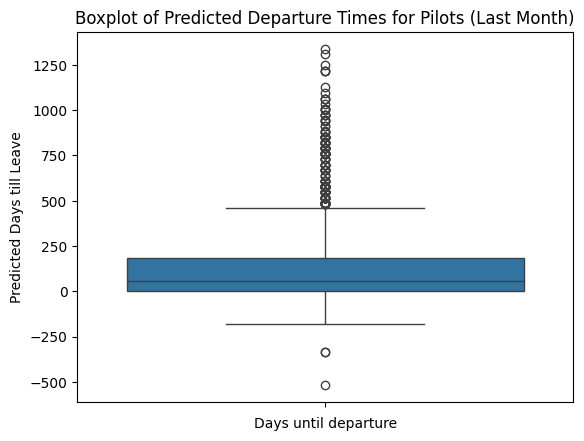

In [211]:
import seaborn as sns

sns.boxplot(df_last_month['Predicted Days till Leave'])
plt.xlabel("Days until departure")
plt.title("Boxplot of Predicted Departure Times for Pilots (Last Month)")
plt.show()


De boxplot laat zien dat de meest voorkomende waarde voor het aantal dagen tot vertrek van piloten ongeveer **200 dagen** is. Dit betekent dat de meeste piloten die zullen vertrekken, dit relatief vroeg aankondigen. Echter, er zijn ook enkele uitschieters boven de 500 dagen, wat suggereert dat sommige piloten een veel langere vertrekperiode hebben.

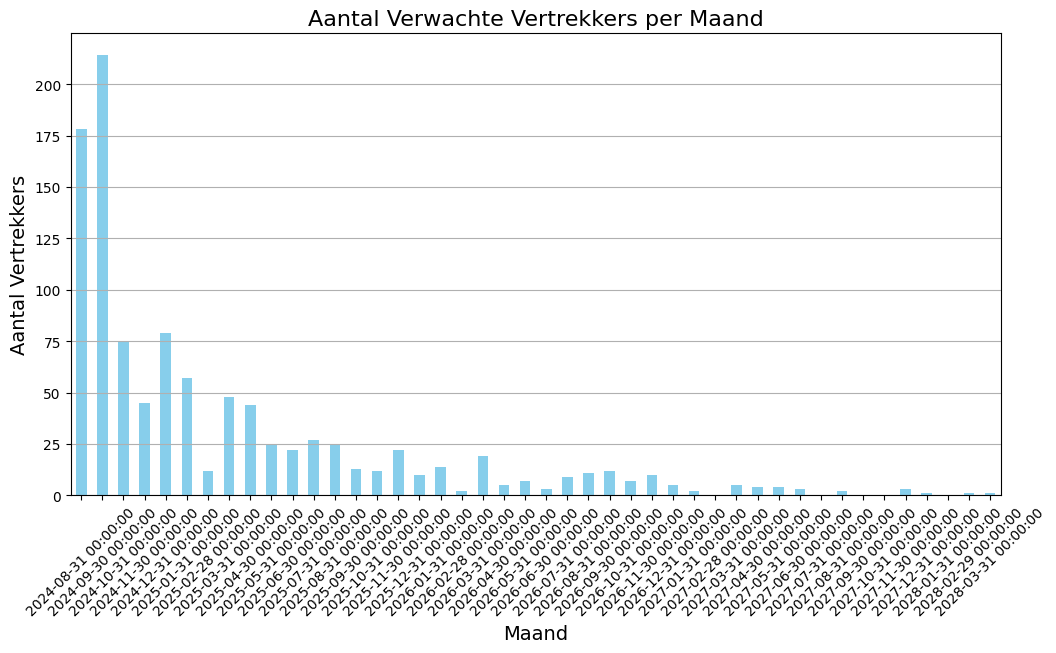

In [212]:
import pandas as pd
import matplotlib.pyplot as plt

# Zorg ervoor dat de kolom 'Departure Date' van het type datetime is in df_last_month
df_last_month['Departure Date'] = pd.to_datetime(df_last_month['Departure Date'])

# Stel de startdatum in
start_date = pd.Timestamp('2024-07-31')

# Filter voor toekomstige vertrekdata (vanaf de startdatum)
future_departures = df_last_month[df_last_month['Departure Date'] > start_date]

# Groepeer op maand en tel het aantal vertrekkers
departure_counts_monthly = future_departures.resample('M', on='Departure Date').size()

# Maak een staafdiagram
plt.figure(figsize=(12, 6))
departure_counts_monthly.plot(kind='bar', color='skyblue')

# Labels en titel toevoegen
plt.title('Aantal Verwachte Vertrekkers per Maand', fontsize=16)
plt.xlabel('Maand', fontsize=14)
plt.ylabel('Aantal Vertrekkers', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


### Voorspeld aantal piloten 
Om een onderbouwd advies te geven aan CRUNCHR ga ik nu een regressieanalyse doen op het aantal aangenomen piloten. Zo kan ik een voorspelling doen op het aantal piloten die er nu zijn, het aantal voorspelde piloten die weggaan en aangenomen worden. 

In [213]:
import pandas as pd
from IPython.display import display

# Zorg ervoor dat je de juiste naam voor de datumkolom gebruikt
df['Timeslice'] = pd.to_datetime(df.index)  # Zet de index om naar datetime als het dat niet al is

# Groepeer de data per maand en tel het aantal 'Is hire' dat True is
monthly_hired = df[df['Is hire']].resample('M').size().reset_index(name='Number of Hires')

# Toon de geaggregeerde data in een tabel
monthly_hired.head()


,Timeslice,Number of Hires
0,2020-08-31,35
1,2020-09-30,26
2,2020-10-31,5
3,2020-11-30,4
4,2020-12-31,6


Hierboven is het aantal aangenomen piloten in de afgelopen 47 maanden te zien. Als je kijkt schommelt de hoeveelheid piloten erg. Hier ga ik nu een regressie op trekken om het aantal nieuwe piloten die worden aangenomen te voorspellen.

Mean Squared Error: 104.64


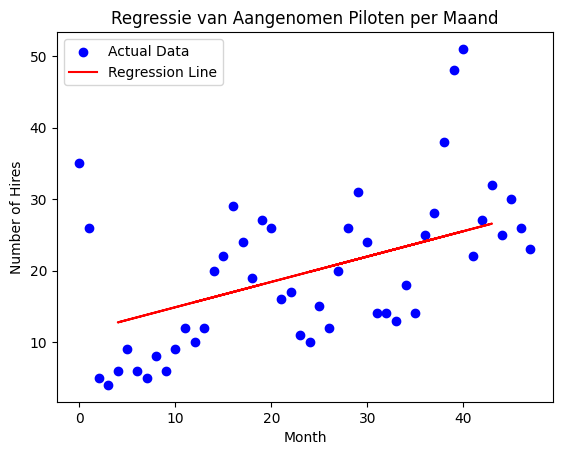

,Predicted Hires
2024-08-31,28
2024-09-30,29
2024-10-31,29
2024-11-30,29
2024-12-31,30
2025-01-31,30
2025-02-28,30
2025-03-31,31
2025-04-30,31
2025-05-31,32


In [214]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Waarschuwingen onderdrukken
warnings.filterwarnings("ignore")

# Stap 1: Filter de DataFrame voor 'Is hire' == True
df_hired = df[df['Is hire']]

# Stap 2: Groepeer per maand en tel het aantal aangenomen piloten
monthly_hired = df_hired.resample('M').size().reset_index(name='Number of Hires')

# Stap 3: Maak een nieuwe kolom voor de maand (in numerieke vorm) voor de regressie
monthly_hired['Month'] = np.arange(len(monthly_hired))

# Stap 4: Splits de data in features (X) en target (y)
X = monthly_hired[['Month']]
y = monthly_hired['Number of Hires']

# Stap 5: Splits de data in trainings- en testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stap 6: Initialiseer en train het regressiemodel
model = LinearRegression()
model.fit(X_train, y_train)

# Stap 7: Maak voorspellingen
y_pred = model.predict(X_test)

# Stap 8: Evaluatie van het model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Stap 9: Plot de resultaten
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X_test, y_pred, color='red', label='Regression Line')
plt.xlabel('Month')
plt.ylabel('Number of Hires')
plt.title('Regressie van Aangenomen Piloten per Maand')
plt.legend()
plt.show()

# Stap 10: Voorspellingen voor de komende maanden
future_months = np.arange(len(monthly_hired), len(monthly_hired) + 43).reshape(-1, 1)  # Voor 12 maanden
future_predictions = model.predict(future_months)

# Ronde de voorspellingen af naar gehele getallen
future_predictions_rounded = np.round(future_predictions).astype(int)

# Toon de voorspellingen
future_df = pd.DataFrame(future_predictions_rounded, columns=['Predicted Hires'])
future_df.index = pd.date_range(start=monthly_hired['Timeslice'].iloc[-1] + pd.DateOffset(months=1), periods=43, freq='M')
future_df.head(10)

Hierboven is een regressieanalyse uitgevoerd om de aanwervingen van piloten per maand te voorspellen. Daaronder zijn de verwachtte aangenomen piloten te zien voor de komende maanden. Ik ga nu de predicted hires en predicted leavers naast elkaar zetten in een dataframe en haal hierbij het aantal piloten van de afgelopen 48 maanden.



Om het aantal verwachte piloten te berekenen, neem je het huidige aantal piloten, telt daar de voorspelde aanstellingen (predicted hires) bij op en trekt de voorspelde vertrekken (predicted departures) er vanaf.

In [215]:
# Stap 1: Zorg ervoor dat de indexen dezelfde zijn
departure_counts_monthly.index.name = 'Departure Date'  # Geef een naam aan de index

# Stap 2: Combineer de DataFrames
combined_df = future_df.join(departure_counts_monthly.rename('Predicted Departures'))

# Zorg ervoor dat de kolom 'Net Change' is toegevoegd
combined_df['Net Change'] = combined_df['Predicted Hires'] - combined_df['Predicted Departures']

# Beginwaarde van het aantal piloten
initial_pilots = 1604

# Voeg een kolom toe voor het cumulatieve aantal piloten, met de startwaarde
combined_df['Aantal piloten'] = combined_df['Net Change'].cumsum() + initial_pilots

# Toon het resultaat om te controleren of de kolom correct is toegevoegd
display(combined_df)


,Predicted Hires,Predicted Departures,Net Change,Aantal piloten
2024-08-31,28,178,-150,1454
2024-09-30,29,214,-185,1269
2024-10-31,29,75,-46,1223
2024-11-30,29,45,-16,1207
2024-12-31,30,79,-49,1158
2025-01-31,30,57,-27,1131
2025-02-28,30,12,18,1149
2025-03-31,31,48,-17,1132
2025-04-30,31,44,-13,1119
2025-05-31,32,25,7,1126


Nu is er een inzicht in het aantal verwachte piloten. Deze waarden worden nu geplot in een visualisatie.

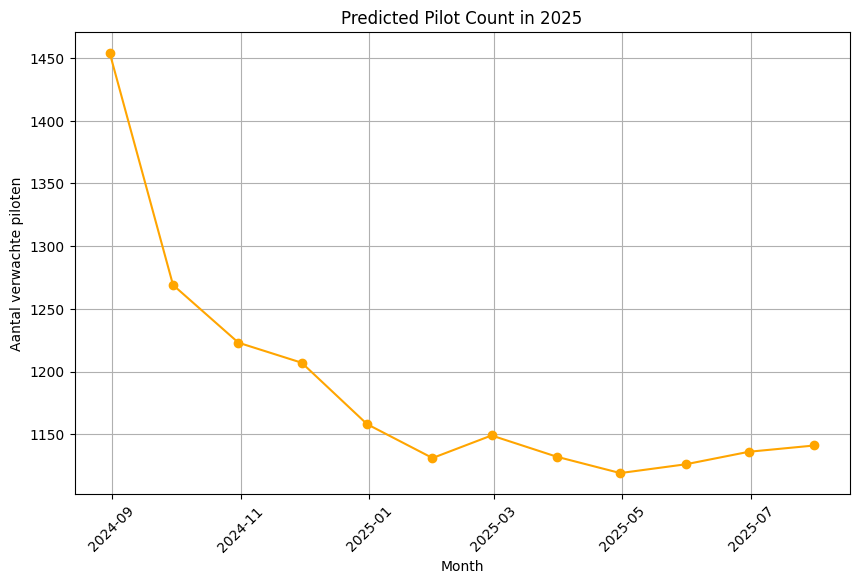

In [225]:
import matplotlib.pyplot as plt
import pandas as pd

start_date = "2024-07-01"
end_date = "2025-07-31"
filtered_df = combined_df[(combined_df.index >= start_date) & (combined_df.index <= end_date)]


# Plot de gefilterde gegevens voor 2025
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['Aantal piloten'], marker='o', color='orange')
plt.xlabel('Month')
plt.ylabel('Aantal verwachte piloten')
plt.title('Predicted Pilot Count in 2025')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In de visualisatie zie je een hele stijle daling wat betekend dat het verwachte aantal piloten van CRUNCHR drastisch zal gaan dalen in de komende maanden. Ik ga nu het aantal piloten van de afgelopen maander ernaast zetten om een beter beeld te krijgen van de daling.  

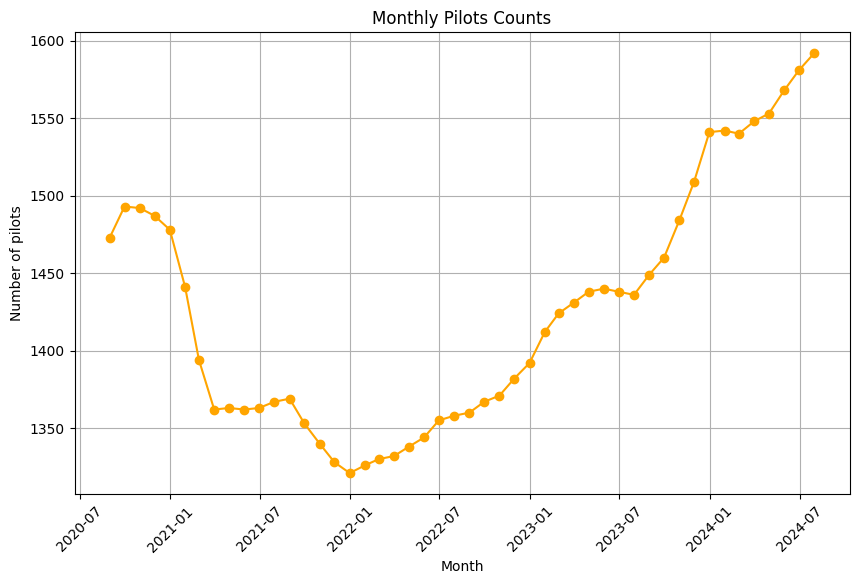

In [174]:
# Filter de gegevens en tel het aantal rijen per maand waar 'is leaver' False is
aantal_piloten = df[df['Is leaver'] == False].resample('M').size()

# Zet de Series om naar een DataFrame en geef de kolom een naam
aantal_piloten = aantal_piloten.to_frame(name='Aantal piloten')

# Plot de leaver-aantallen per maand
plt.figure(figsize=(10, 6))
plt.plot(aantal_piloten.index, aantal_piloten['Aantal piloten'], marker='o', color='orange')
plt.xlabel('Month')
plt.ylabel('Number of pilots')
plt.title('Monthly Pilots Counts')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



Hier zie je het aantal piloten voor de maanden waarvoor CRUNCHR data beschikbaar heeft. In het onderstaande lijndiagram worden het werkelijke aantal piloten en de verwachte aantallen weergegeven.

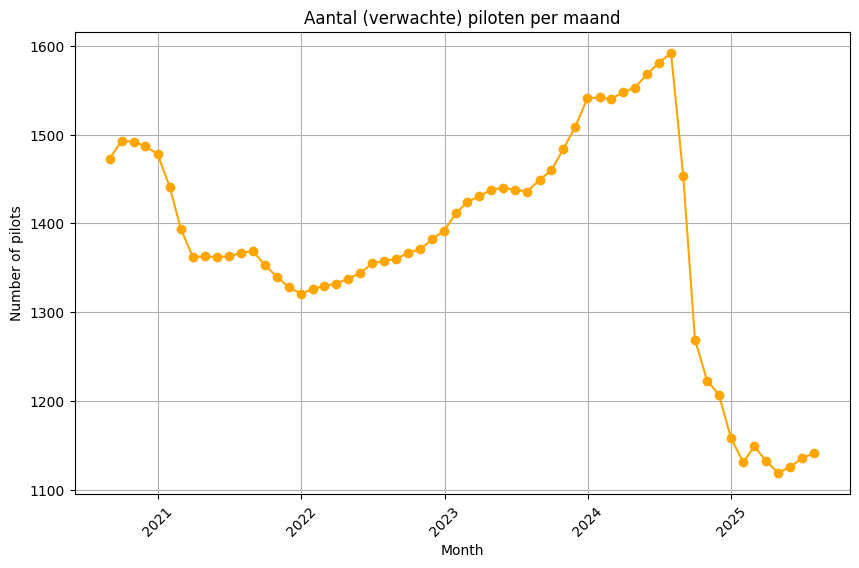

In [218]:
# Maak een nieuwe DataFrame met alleen de kolom "Predicted Pilot Count" en gebruik de bestaande index
nieuwe_df = filtered_df[['Aantal piloten']]

# Voorbeeld code om de dataframes onder elkaar te plaatsen
# Vervang 'combined_df' en 'aantal_piloten' met de juiste namen als die anders zijn
samengevoegd_df = pd.concat([aantal_piloten, nieuwe_df])

# Toon het resultaat om te controleren
# Plot de leaver-aantallen per maand
plt.figure(figsize=(10, 6))
plt.plot(samengevoegd_df.index, samengevoegd_df['Aantal piloten'], marker='o', color='orange')
plt.xlabel('Month')
plt.ylabel('Number of pilots')
plt.title('Aantal (verwachte) piloten per maand')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()




In de bovenstaande grafiek wordt het aantal piloten bij CRUNCHR Airlines weergegeven. De scherpe daling komt overeen met de voorspellingen van ons machine learning-algoritme, en deze visualisatie toont duidelijk de impact van deze daling op het totale pilotenbestand.

In deze data-oplossing is echter nog geen rekening gehouden met het vertrek van recent aangenomen collega’s. Hierdoor kunnen we niet te ver vooruitkijken, omdat we nog geen voorspellingen kunnen doen over het vertrekgedrag van nieuwe medewerkers. Dit leidt tot het advies voor een vervolgonderzoek. Zodra er meer data beschikbaar komt over het wervingsproces, specifieke methoden, en bijbehorende kosten, zal het noodzakelijk zijn om aanzienlijk meer te investeren. Het huidige tekort aan piloten loopt al op, en onze data-analyse laat zien dat dit probleem zonder verdere interventie alleen maar zal toenemen.